# Sentiment Analysis Using ML

In [2]:
#Installing Dependencies
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from spacy.matcher import PhraseMatcher
import spacy
import torch 
import os
import pandas as pd
import re

In [5]:
# Model for aspect extraction
nlp = spacy.load("en_core_web_sm")

# Model for sentiment classification
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False) 
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [70]:
#ASPECT CATEGORIZATION

# Load custom aspect category datasets
def load_dataset(file_path, column_name):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if column_name in df.columns:
            cleaned_food = (
                df[column_name].dropna().str.lower() 
                .str.replace(r"\s*\(.*?\)", "", regex=True) 
                .str.strip().unique().tolist()
            )
            return cleaned_food
        else:
            print(f"Column '{column_name}' not found in {file_path}")
    else:
        print(f"File not found: {file_path}")
    return []

# Load dataset
nigerian_foods = load_dataset(r"C:\Users\PT WORLD\Downloads\Nigerian Foods.csv", "Food_Name")

# Phrase matcher for Nigerian foods
food_matcher = PhraseMatcher(nlp.vocab, attr = "LOWER")

common_foods = [
    'jollof spaghetti', 'rice and beans', 'meat pie', 'bread and egg', 'special rice', 'egg roll', 'fish pie',
    'chicken and chips', 'veggie roll', 'caleb roll', 'mixed rice', 'asun rice'
]

all_foods = list(set(nigerian_foods + common_foods))

food_patterns = [nlp(food) for food in all_foods]
food_matcher.add("NIGERIAN_FOOD", food_patterns)

print(f"Number of Nigerian foods: {len(nigerian_foods)} \n")
print(nigerian_foods)

Number of Nigerian foods: 68 

['abacha', 'abacha and ugba', 'afang soup', 'afia efere', 'agege bread', 'agidi', 'akara', 'amala and ewedu soup', 'ayamase sauce', 'banga soup', 'bitterleaf soup', 'blended ogbono soup', 'bole and fish', 'bole', 'boli', 'bushmeat stew', 'chin chin', 'chinchinga', 'coconut candy', 'coconut rice', 'edide', 'edikaikong soup', 'edikang ikong', 'efo egusi', 'efo elegusi', 'efo riro', 'egusi soup', 'ekpang nkukwo', 'ekpang nla', 'ekpang ubi', 'ewedu soup', 'fried rice', 'fufu and egusi soup', 'gizdodo', 'ikokore', 'isi ewu', 'iyan', 'jollof rice', 'kilishi', 'kilishi stew', 'kuli kuli', 'kuli kuli snacks', 'kunu', 'miyan taushe', 'moi moi', 'nkwobi', 'obe ata', 'ofada rice', 'ofada rice and ayamase sauce', 'ofe nsala', 'ogbono soup', 'ogi', 'oha soup', 'okra soup', 'okro stew', 'owo soup', 'pepper soup', 'plantain chips', 'pounded yam', 'pounded yam and egusi soup', 'puff puff', 'semovita', 'semovita with edikaikong soup', 'suya', 'tom brown', 'ukodo', 'ukwa',

In [8]:
aspect_categories = {
    'food': nigerian_foods + ['food', 'amala', 'appetizer', 'beans', 'bread', 'breakfast', 'burger', 'beef', 'chicken', 'chinchin', 
            'cuisine', 'cereal', 'dessert', 'dish', 'dodo', 'doughnut', 'eba', 'egusi', 'entree', 'fish', 
            'gari', 'icecream', 'indomie', 'lunch', 'macaroni', 'meal', 'meals', 'meat', 'meatpie', 'milk', 'milo', 
            'potatoe', 'recipe','moimoi', 'noodles', 'pasta', 'plantain', 'pizza', 'porridge', 
            'rice', 'salad', 'sandwich', 'semo', 'shawarma', 'snacks','soup', 'spag', 'stew',  
            'spaghetti', 'swallow', 'turkey', 'toast', 'biscuit', 'apple', 'watermelon', 'yam', 'yamarita'], 

    'service': ['service', 'staff', 'servers', 'waiter', 'waitress', 'attendant', 'employee', 'team', 
                'customer service', 'support', 'help', 'assistance', 'line', 'queue'],

    'portion': ['portions', 'portion'],
    
    'price': ['price', 'cost', 'expensive', 'cheap', 'pricing', 'value', 'rate', 'charge', 
              'fee', 'ticket', 'bill', 'prices'],
    
    'ambience': ['ambience', 'atmosphere', 'environment', 'mood', 'setting', 'decor', 'interior', 
                 'lighting', 'music', 'view', 'space', 'room', 'area', 'cafeteria', 'cafe', 'dining' ]
}

# Categorize Aspects into predefined categories
def categorize_aspect(aspect):
    aspect_lower = aspect.lower()

    for category, keywords in aspect_categories.items():
        if aspect_lower in keywords:
            return category
    
    return 'other'

### Extract aspects

In [9]:
def extract_aspects(sentence):
    doc = nlp(sentence)
    aspects = []

    covered_tokens = set()
    
    # Find all matching foods using PhraseMatcher
    food_matches = food_matcher(doc)
    for match_id, start, end in food_matches:
        span = doc[start:end]
        aspects.append({
            'text': span.text.lower(),
            'category': 'food'
        })
        
        for i in range(start, end):
            covered_tokens.add(i)

    #Extract noun phrases for other aspects
    for chunk in doc.noun_chunks:
        # Skip if all tokens in phrase are already covered
        if all(i in covered_tokens for i in range(chunk.start, chunk.end)):
            continue
            
        # Skip single pronouns and determiners
        if len(chunk) == 1 and chunk[0].pos_ in ['PRON', 'DET']:
            continue
            
        chunk_text = chunk.text.lower()
        category = categorize_aspect(chunk_text)
        
        # Only add aspects with known categories to avoid noise
        if category != 'other':
            aspects.append({
                'text': chunk_text,
                'category': category
            })

            for i in range(chunk.start, chunk.end):
                covered_tokens.add(i) 

    # Extract individual nouns not already covered for completeness
    for token in doc:
        if token.i not in covered_tokens and token.pos_ in ['NOUN', 'PROPN']:
            token_text = token.text.lower()
            category = categorize_aspect(token_text)
            
            # Only add if it's a known category
            if category != 'other':
                aspects.append({
                    'text': token_text,
                    'category': category
                })
                covered_tokens.add(token.i)
    
    return aspects

### Predict Sentiment

In [10]:
def predict_sentiment(sentence, aspect):
    sentiment_labels = {
        0: "negative",
        1: "neutral", 
        2: "positive"
    }
 
    input_text = f"{sentence} [ASP] {aspect} [ASP]"
    
    inputs = tokenizer(
        input_text, 
        return_tensors="pt", 
        truncation=True, 
        max_length=512
    )
    
    # Predict sentiment
    with torch.no_grad():
        outputs = model(**inputs)
        sentiment_pred = torch.argmax(outputs.logits, dim=1).item()
    
    return sentiment_labels[sentiment_pred]

### Final Aspect-Based Classification

In [11]:
def absa(sentence):
    # Extract aspects
    aspects = extract_aspects(sentence)
    
    # Predict sentiment for each aspect
    aspect_sentiments = {}
    for aspect_info in aspects:
        aspect = aspect_info['text']
        category = aspect_info['category']
        
        sentiment = predict_sentiment(sentence, aspect)
        aspect_sentiments[aspect] = {
            'sentiment': sentiment,
            'category': category
        }
    
    return aspect_sentiments

In [12]:
if __name__ == "__main__":
    # Test sentences
    test_sentences = [
    "The food portions are too small, i guess it’s because of the takeaway and also they way they serve"
]
    
    # Analyze each sentence
    for sentence in test_sentences:
        print(f"\nSentence: {sentence}")
        results = absa(sentence)
        for aspect, details in results.items():
            print(f"{aspect}: Sentiment = {details['sentiment']}, Category = {details['category']}")


Sentence: The food portions are too small, i guess it’s because of the takeaway and also they way they serve
food: Sentiment = negative, Category = food
portions: Sentiment = negative, Category = portion


### Fine-tune ABSA Model

In [62]:
from sklearn.metrics import classification_report

#Load in training dataset
df = pd.read_csv(r"C:\Users\PT WORLD\Downloads\Restaurants_Train_v2.csv", usecols=["Sentence", "Aspect Term", "polarity"])

df = df.rename(columns={
    "Sentence": "sentence",
    "Aspect Term": "aspect",
    "polarity": "true_sentiment"
})

df = df[df['true_sentiment'] != 'conflict']
print(df['true_sentiment'].value_counts())

print(df.shape)
df.sample(5)

true_sentiment
positive    2164
negative     805
neutral      633
Name: count, dtype: int64
(3602, 3)


,sentence,aspect,true_sentiment
326,"The have over 100 different beers to offer thier guest so that made my husband very happy and the food was delicious, if I must recommend a dish it must be the pumkin tortelini.",pumkin tortelini,positive
3263,This place has the best Chinese style BBQ ribs in the city.,BBQ ribs,positive
1332,"Whether it's the parmesean porcini souffle or the lamb glazed with balsamic vinegar, you will surely be transported to Northern Italy with one bite.",parmesean porcini souffle,positive
2739,I recommend this place to everyone who asks me where to go for a good meal.,meal,positive
2158,I would have gotten some cole slaw and a knish if my stomach had more space.,knish,neutral


In [5]:
# TRAINING, TESTING AND EVALUATION FOR ABSA MODEL

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Dataset Class
class ABSADataset(Dataset):
    def __init__(self, sentences, aspects, labels, tokenizer):
        self.sentences = sentences
        self.aspects = aspects
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        aspect = str(self.aspects[idx])
        
        input_text = f"{sentence} [ASP] {aspect} [ASP]"
        
        encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=256,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Training function
def train_model(model, dataloader, epochs=2):
    model.train()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    for epoch in range(epochs):
        print(f"Training Epoch {epoch+1}/{epochs}")
        total_loss = 0
        
        for batch in tqdm(dataloader, desc="Training"):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Average Loss: {avg_loss:.4f}")

# Testing function
def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.numpy())
            true_labels.extend(labels.numpy())
    
    return predictions, true_labels

# Evaluation function
def evaluate_model(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        true_labels, 
        predictions, 
        target_names=['Negative', 'Neutral', 'Positive']
    ))
    
    return accuracy

# Main training and evaluation pipeline
def run_training_pipeline():
    # Prepare data from the loaded df
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    
    # Clean the data
    df_clean = df.dropna().copy()
    df_clean = df_clean[df_clean['true_sentiment'].isin(sentiment_map.keys())]
    
    sentences = df_clean['sentence'].tolist()
    aspects = df_clean['aspect'].tolist()
    labels = [sentiment_map[label] for label in df_clean['true_sentiment'].tolist()]
    
    print(f"Total samples: {len(sentences)}")
    print(f"Label distribution:")
    for label, count in pd.Series(labels).value_counts().sort_index().items():
        sentiment_name = list(sentiment_map.keys())[list(sentiment_map.values()).index(label)]
        print(f"  {sentiment_name}: {count}")
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        list(zip(sentences, aspects)), labels, 
        test_size=0.2, random_state=42, stratify=labels
    )
    
    train_sentences, train_aspects = zip(*X_train)
    test_sentences, test_aspects = zip(*X_test)
    
    print(f"\nTrain samples: {len(train_sentences)}")
    print(f"Test samples: {len(test_sentences)}")
    
    # Create datasets
    train_dataset = ABSADataset(train_sentences, train_aspects, y_train, tokenizer)
    test_dataset = ABSADataset(test_sentences, test_aspects, y_test, tokenizer)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    # Train the model
    print("\n" + "="*50)
    print("TRAINING PHASE")
    print("="*50)
    train_model(model, train_loader, epochs=2)
    
    # Test the model
    print("\n" + "="*50)
    print("TESTING PHASE")
    print("="*50)
    predictions, true_labels = test_model(model, test_loader)
    
    # Evaluate the model
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    accuracy = evaluate_model(predictions, true_labels)
    
    # Save the fine-tuned model
    model.save_pretrained("./fine_tuned_absa_model")
    tokenizer.save_pretrained("./fine_tuned_absa_model")
    print(f"\nFine-tuned model saved to './fine_tuned_absa_model'")
    
    return accuracy

# Run the complete pipeline
final_accuracy = run_training_pipeline()
print(f"\nTraining completed! Final accuracy: {final_accuracy:.4f}")

NameError: name 'df' is not defined

### Confusion Matrix

In [18]:
# Re-create test data and get predictions for confusion matrix
from sklearn.model_selection import train_test_split

# Prepare the same test data as before
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_clean = df.dropna().copy()
df_clean = df_clean[df_clean['true_sentiment'].isin(sentiment_map.keys())]

sentences = df_clean['sentence'].tolist()
aspects = df_clean['aspect'].tolist()
labels = [sentiment_map[label] for label in df_clean['true_sentiment'].tolist()]

# Split the same way (same random_state to get same test set)
X_train, X_test, y_train, y_test = train_test_split(
    list(zip(sentences, aspects)), labels, 
    test_size=0.2, random_state=42, stratify=labels
)

test_sentences, test_aspects = zip(*X_test)

# Create test dataset and dataloader
test_dataset = ABSADataset(test_sentences, test_aspects, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get predictions
predictions, true_labels = test_model(model, test_loader)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 91/91 [39:33<00:00, 26.09s/it]


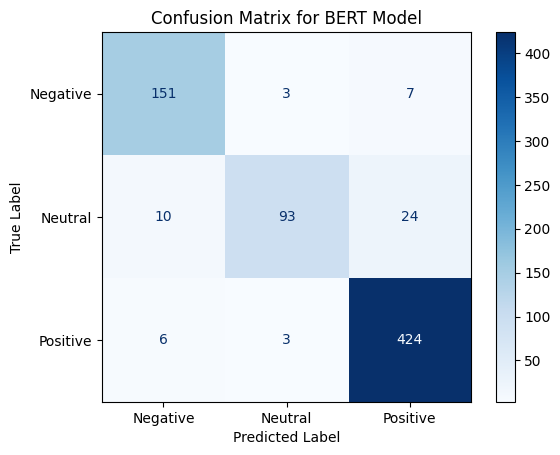

In [20]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for BERT Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Sentiment Classification of Student Feedback

In [21]:
import pandas as pd
from collections import defaultdict

# Load the reviews dataset
df = pd.read_csv(r"C:\Users\PT WORLD\Downloads\Caleb_Student_Food_Review.csv")

df = df.drop(columns=["Timestamp"])

df = df.stack().reset_index(drop=True).to_frame(name='student_reviews')

print(df.shape)
df.head()

(408, 1)


,student_reviews
0,The food is just basic and overpriced
1,The veggie roll is actually nice
2,"The service time, right now it’s way too slow"
3,I like how some of the staff are friendly and ...
4,The food is okay overall but not much variety


In [23]:
#Prediction

# Load fine-tuned model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

fine_tuned_tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_absa_model", use_fast=False)
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_absa_model")

# Updated predict_sentiment function for fine-tuned model
def predict_sentiment_finetuned(sentence, aspect):
    sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
    input_text = f"{sentence} [ASP] {aspect} [ASP]"
    inputs = fine_tuned_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256)
    
    with torch.no_grad():
        outputs = fine_tuned_model(**inputs)
        sentiment_pred = torch.argmax(outputs.logits, dim=1).item()
    
    return sentiment_labels[sentiment_pred]

# Updated ABSA function using fine-tuned model
def absa_finetuned(sentence):
    aspects = extract_aspects(sentence)
    aspect_sentiments = {}
    for aspect_info in aspects:
        aspect = aspect_info['text']
        category = aspect_info['category']
        sentiment = predict_sentiment_finetuned(sentence, aspect)
        aspect_sentiments[aspect] = {'sentiment': sentiment, 'category': category}
    return aspect_sentiments

# Initialize counters for each category and sentiment
category_sentiments = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0})

# Process each review
for idx, row in enumerate(df['student_reviews']):
    if pd.isna(row):
        continue
        
    # Extract aspects and sentiments using fine-tuned model
    aspect_sentiments = absa_finetuned(str(row))
    
    # Aggregate results by category
    for aspect, info in aspect_sentiments.items():
        category = info['category']
        sentiment = info['sentiment']
        
        category_sentiments[category][sentiment] += 1
        category_sentiments[category]['total'] += 1

# Convert defaultdict to regular dict and display results
results = {k: dict(v) for k, v in category_sentiments.items()}

print("Sentiment Analysis Results:")
for category, counts in results.items():
    print(f"\n{category.upper()}:")
    print(f"  Positive: {counts['positive']}")
    print(f"  Neutral: {counts['neutral']}")
    print(f"  Negative: {counts['negative']}")
    print(f"  Total mentions: {counts['total']}")

Sentiment Analysis Results:

FOOD:
  Positive: 100
  Neutral: 61
  Negative: 127
  Total mentions: 288

SERVICE:
  Positive: 19
  Neutral: 8
  Negative: 61
  Total mentions: 88

PORTION:
  Positive: 7
  Neutral: 5
  Negative: 45
  Total mentions: 57

AMBIENCE:
  Positive: 12
  Neutral: 4
  Negative: 22
  Total mentions: 38

PRICE:
  Positive: 5
  Neutral: 3
  Negative: 10
  Total mentions: 18


### Sentiment Doughnut chart

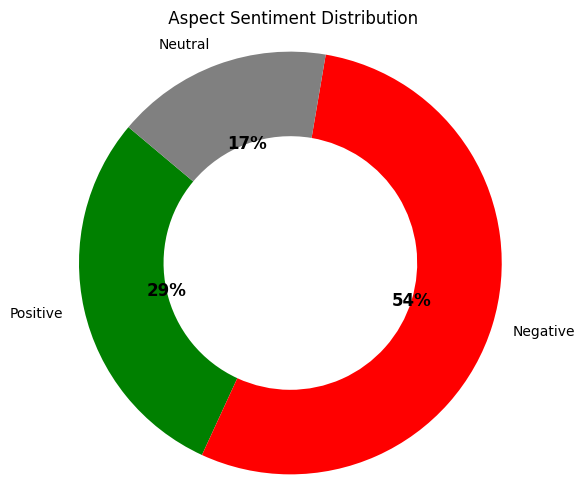

In [38]:
import matplotlib.pyplot as plt

labels = ['Positive', 'Negative', 'Neutral']
sizes = [143, 265, 81]
#colors = ['#bbbbbb', '#888888', '#dddddd']  # light grey, grey, lighter grey
colors = ['green', 'red', 'grey']

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%.0f%%',
    startangle=140,
    wedgeprops={'width': 0.4}  # Creates the doughnut effect
)

# Title and formatting
ax.set_title(' Aspect Sentiment Distribution')
plt.setp(autotexts, size=12, weight='bold')
ax.axis('equal')  

plt.show()

### Horizontal Diverging Bar Chart

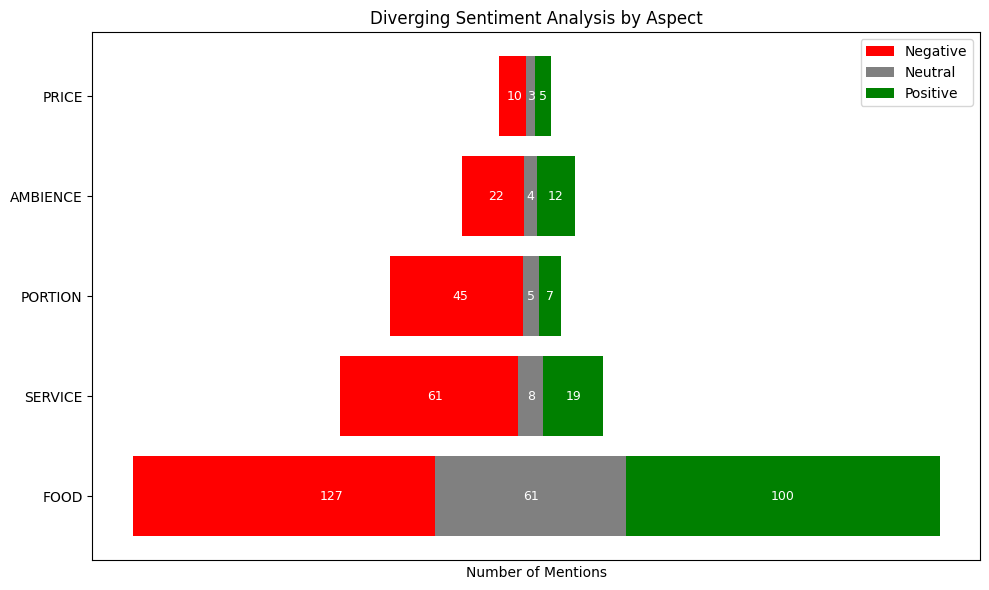

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Fixed data and order
aspects = ['FOOD', 'SERVICE', 'PORTION', 'AMBIENCE', 'PRICE']
positive = np.array([100, 19, 7, 12, 5])
neutral = np.array([61, 8, 5, 4, 3])
negative = np.array([127, 61, 45, 22, 10])

y_pos = np.arange(len(aspects))

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot negative (left)
ax.barh(y_pos, -negative, color='red', label='Negative')

# Plot neutral (split left and right)
ax.barh(y_pos, -neutral / 2, color='gray')
ax.barh(y_pos,  neutral / 2, color='gray', label='Neutral')

# Plot positive (right)
ax.barh(y_pos, positive, left=neutral / 2, color='green', label='Positive')

# Y-axis formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(aspects)

# X-axis formatting
ax.set_xlabel('Number of Mentions')
ax.set_xticks([])          

# Title and legend
ax.set_title('Diverging Sentiment Analysis by Aspect')
ax.legend(loc='upper right')

# Value labels
for i in range(len(aspects)):
    ax.text(-negative[i] / 2, i, str(negative[i]), va='center', ha='center', color='white', fontsize=9)
    ax.text(0, i, str(neutral[i]), va='center', ha='center', color='white', fontsize=9)
    ax.text(positive[i] / 2 + neutral[i] / 2, i, str(positive[i]), va='center', ha='center', color='white', fontsize=9)

plt.tight_layout()
plt.show()